# Hierarchical Clustering


## 1. Create a dendrogram to find the optimal number of clusters
- once for the rudamentary features and once with the additional ones


In [1]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import hierarchicalClustering_functions as hcf
import pandas as pd
import numpy as np


#from pickle file
basic_features_normalized_all_df =  pd.read_pickle('basic_normalized_flow.pkl')
all_normalized_all_df = pd.read_pickle('all_normalized_flow.pkl')
all_features_all = pd.read_pickle('all_features_flow.pkl')


lower_bound = 2
num_clusters = 70

#create df with Stationsnummer as column and fill it with statinsnummer from all_features_all
cluster_labels_hierachical_basic = all_features_all['Stationsnummer'].copy()

cluster_labels_hierachical_basic.head()
cluster_labels_hierachical_basic, cluster_scores_hierachical_basic = hcf.hierarchical_clustering(all_features_all, basic_features_normalized_all_df, lower_bound, num_clusters)
cluster_labels_hierachical_additional, cluster_scores_hierachical_additional = hcf.hierarchical_clustering(all_features_all, all_normalized_all_df, lower_bound, num_clusters)

#save the cluster labels to a csv file in the current directory
cluster_labels_hierachical_basic.to_csv('cluster_labels_hierachical_basic_flow.csv')
#save the cluster scores to a csv file
cluster_scores_hierachical_basic.to_csv('cluster_scores_hierachical_basic_flow.csv')

#save the cluster labels to a csv file
cluster_labels_hierachical_additional.to_csv('cluster_labels_hierachical_additional_flow.csv')
#save the cluster scores to a csv file
cluster_scores_hierachical_additional.to_csv('cluster_scores_hierachical_additional_flow.csv')



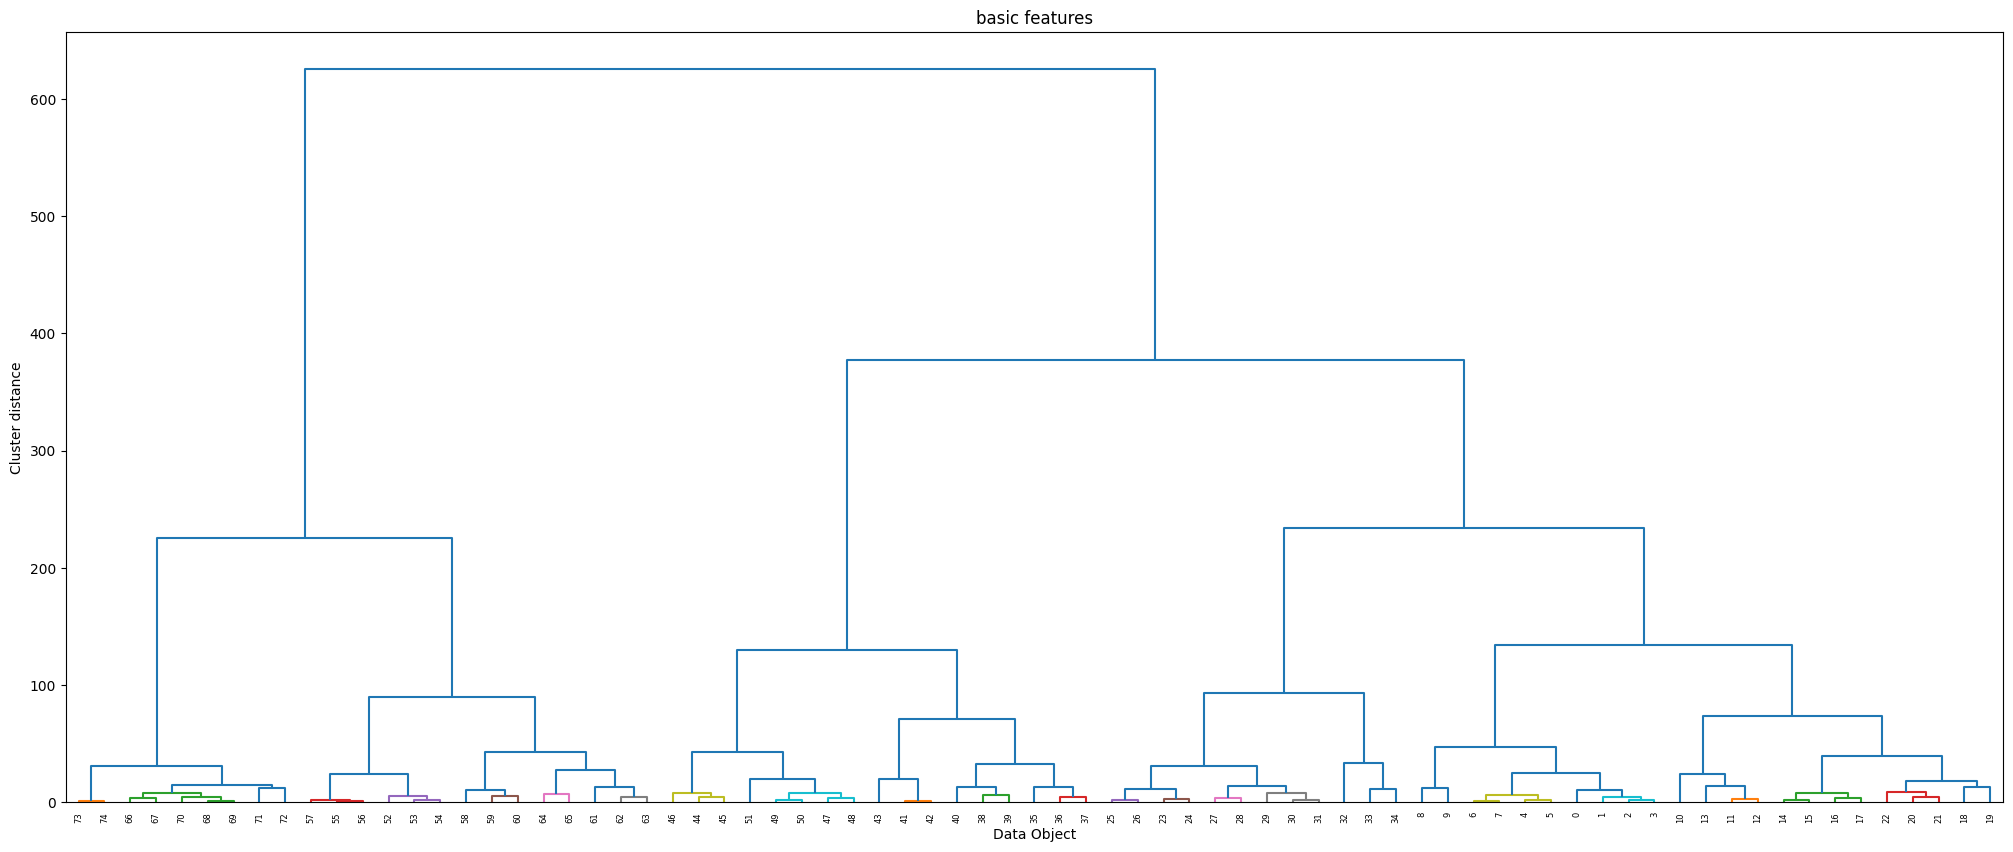

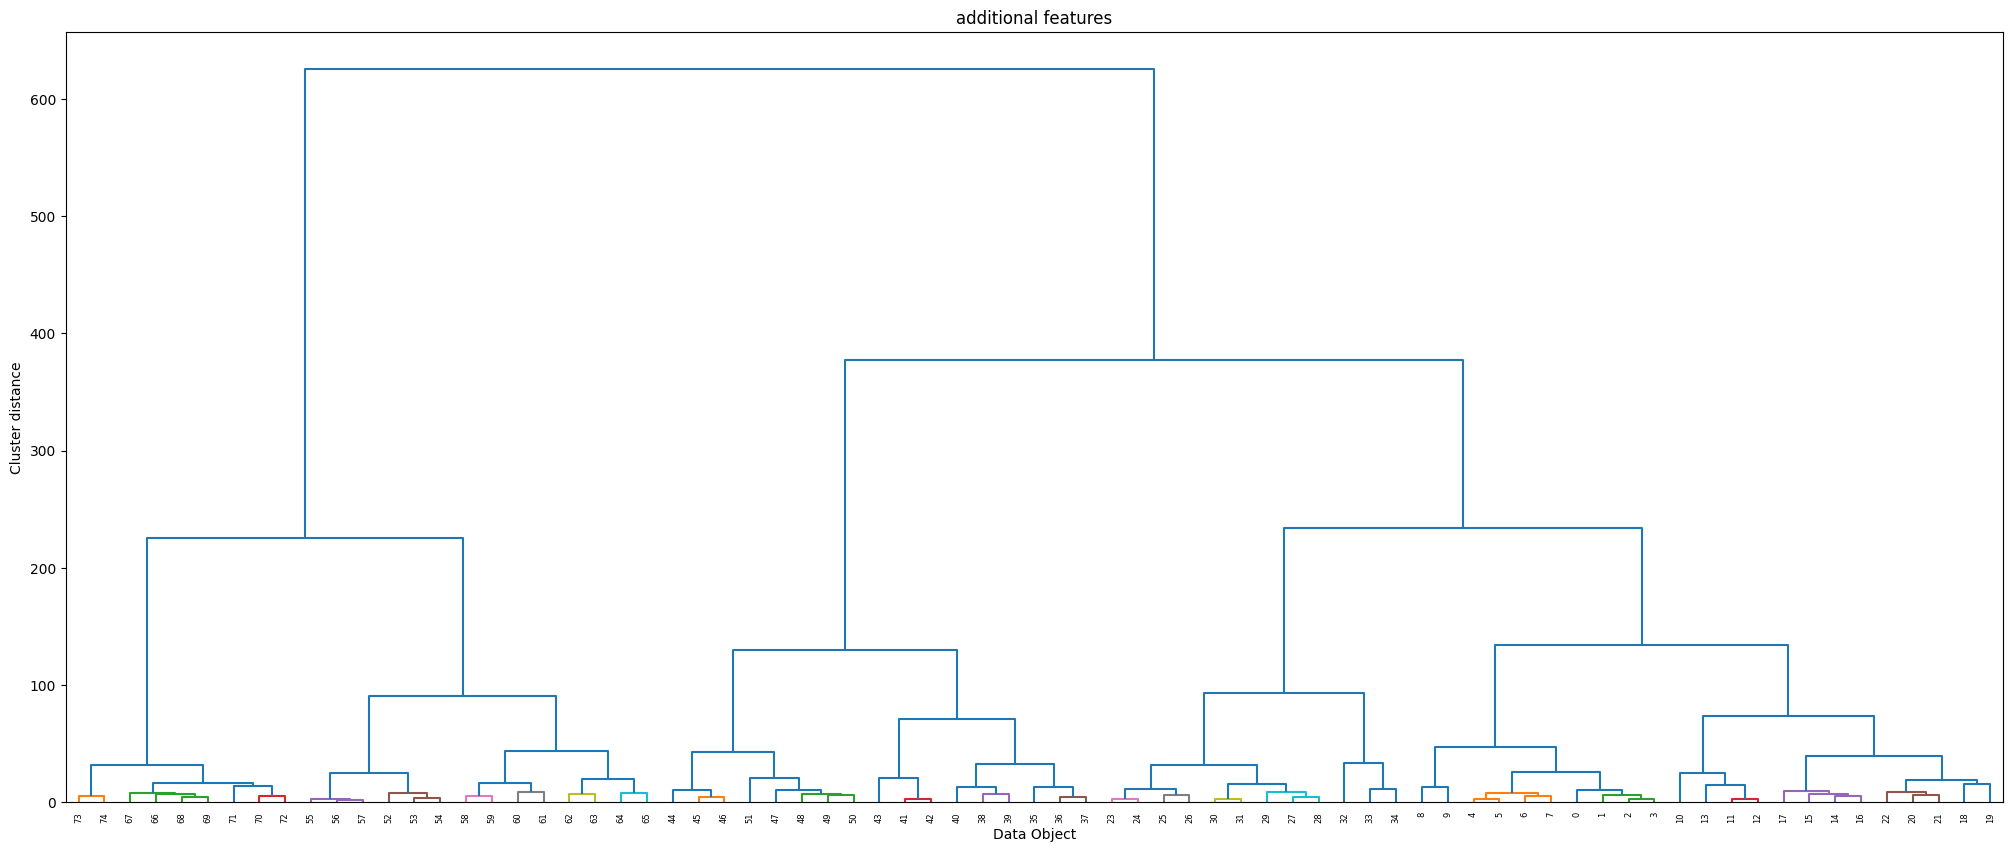

In [2]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import single, complete

#create two dendrograms one for the basic features and one for the additional features

linkage_array = complete(basic_features_normalized_all_df)
plt.figure(figsize=(25, 10))
dendrogram(linkage_array, color_threshold=10.0)
plt.title("basic features")
plt.xlabel("Data Object")
plt.ylabel("Cluster distance")
plt.show()

linkage_array = complete(all_normalized_all_df)
plt.figure(figsize=(25, 10))
dendrogram(linkage_array, color_threshold=10.0)
plt.title("additional features")
plt.xlabel("Data Object")
plt.ylabel("Cluster distance")
plt.show()

## Result:

- one can clearly see that between the rudimentary features and the additional ones there is a not a real difference in the clustering


2. Plot the clusters on mds plots 
- once for the rudamentary features and once with the additional ones


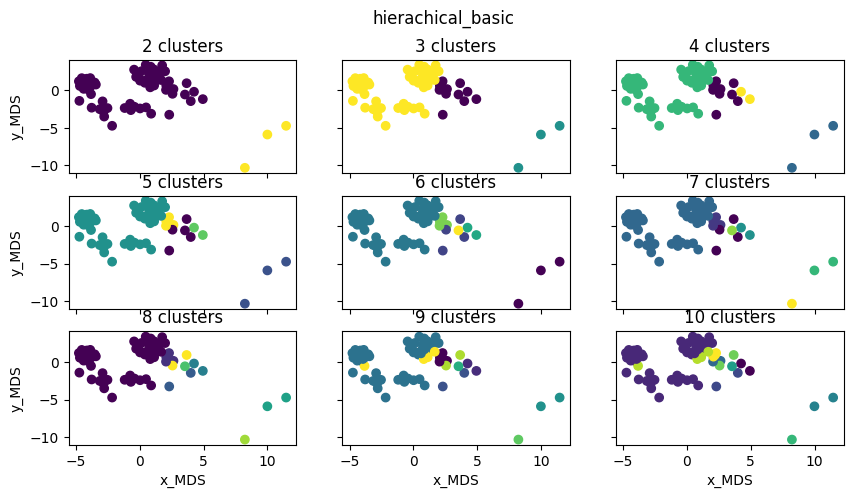

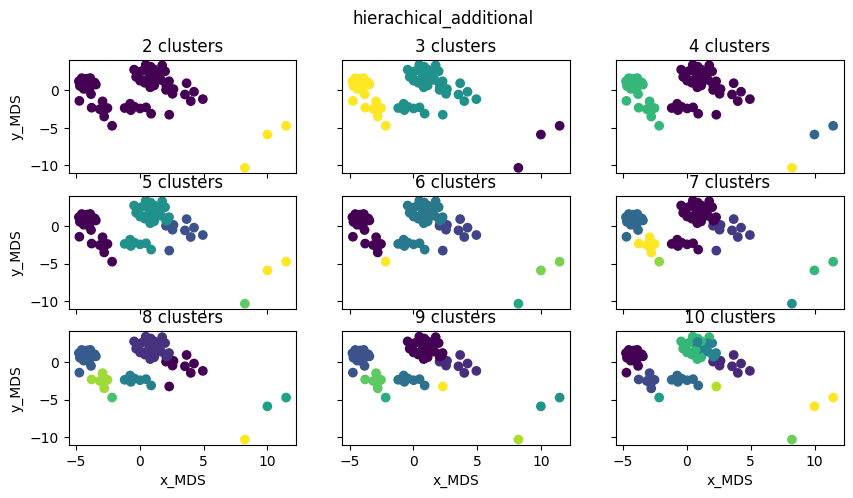

In [3]:
import math as math


all_mds_all_df = pd.read_pickle('all_mds_flow.pkl')
basic_mds_all_df = pd.read_pickle('basic_mds_flow.pkl')

def plot_clusters(number_of_plots, num_columns, lower_bound, mds_representation, cluster_labels, name):
    # plot the clusters
    num_rows = math.ceil(number_of_plots/num_columns) 
    j = 0
    i = 0

    current_cluster = lower_bound
   


    fig, axs = plt.subplots(num_rows, num_columns)
    fig.set_size_inches(10, 5)
    fig.suptitle(name)
    while current_cluster < number_of_plots + lower_bound:
        axs[j,i].scatter(mds_representation['x_MDS'] , mds_representation['y_MDS'], c=cluster_labels[str(current_cluster) + ' clusters'])
        axs[j,i].set_title(str(current_cluster) + ' clusters')
        #set the height of the subplots to be the same as the width
        #axs[j,i].set_aspect('equal')
        i = i+1
        if(i % 3 ==0):
            j = j+1
            i = 0
        current_cluster = current_cluster + 1

    for ax in axs.flat:
        ax.set(xlabel='x_MDS', ylabel='y_MDS')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


plot_clusters(9,3,2, all_mds_all_df, cluster_labels_hierachical_basic,  'hierachical_basic')
plot_clusters(9,3,2, all_mds_all_df, cluster_labels_hierachical_additional, 'hierachical_additional')


## 3. Evaluate the calculated metrics
- once for the rudamentary features and once with the additional ones

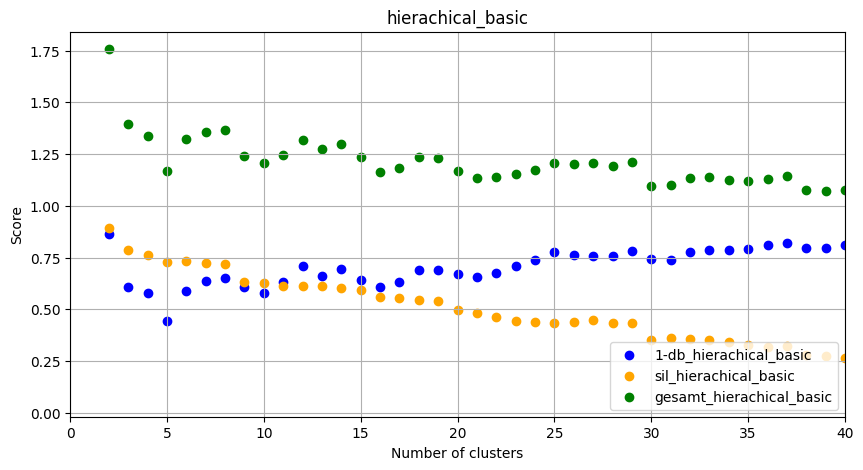

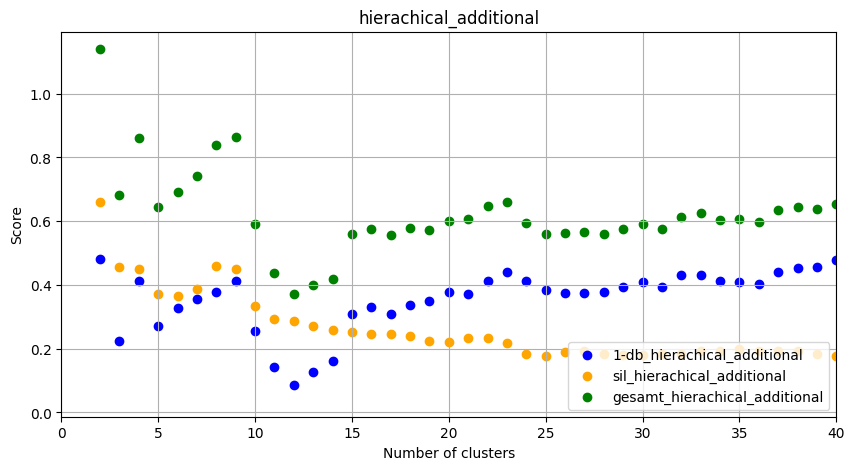

In [4]:
from matplotlib import ticker


def plot_scores(cluster_scores, cluster_option):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(cluster_scores['num_clusters'], 1-cluster_scores['davies_bouldin_score'], label='1-db_' + cluster_option, color='blue')
    ax.scatter(cluster_scores['num_clusters'], cluster_scores['silhouette_score'], label='sil_' +  cluster_option, color='orange')
    ax.scatter(cluster_scores['num_clusters'], -cluster_scores['davies_bouldin_score']+ 1 + cluster_scores['silhouette_score'], label='gesamt_' + cluster_option, color='green')
    ax.grid(True, which='both')
    #reduce x axis to0 to 20
    ax.set_xlim(0,40)

    #only show points not lines
    
      
    ax.set_title(cluster_option)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Score')
    #make graphs semi transparent
    for line in ax.get_lines():
        line.set_alpha(0.5)

    #show the legend in the lower right corner
    ax.legend(loc = 'lower right')
    plt.show()



plot_scores(cluster_scores_hierachical_basic, 'hierachical_basic')
plot_scores(cluster_scores_hierachical_additional, 'hierachical_additional')


## Result:
- one can clearly see that between the rudimentary features and the additional ones there is no difference in the scores
- at 9 clusters a first local maxima is reached and after that the clustering does not get very much better


## 3. Show clusters on the map


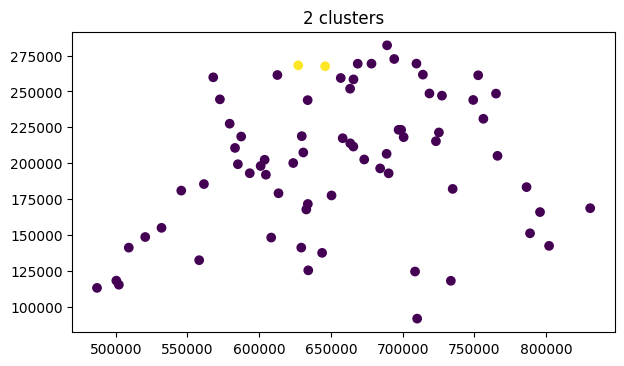

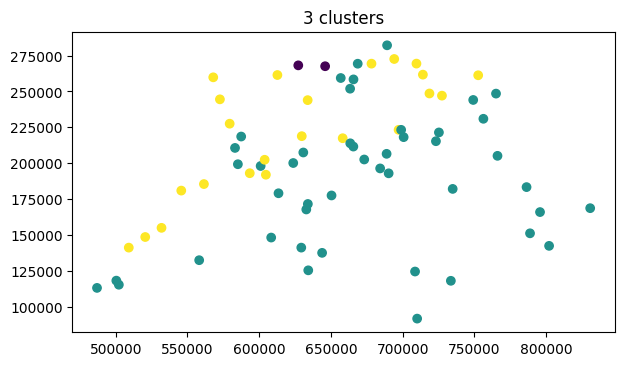

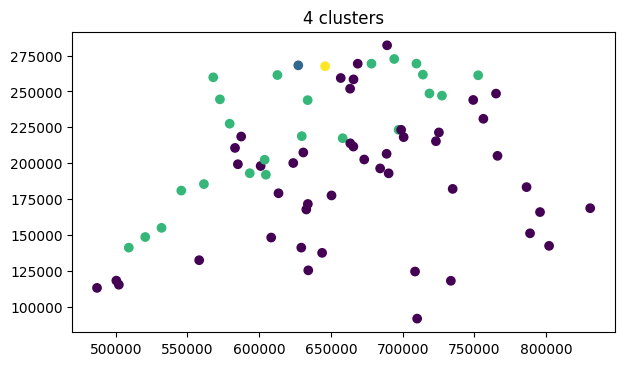

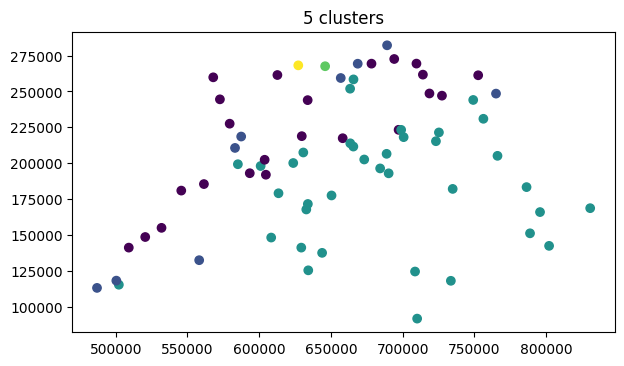

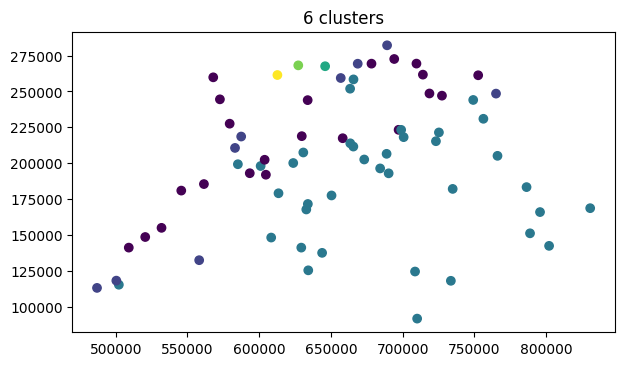

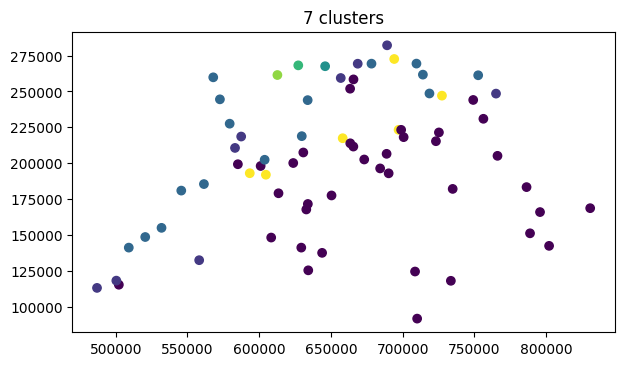

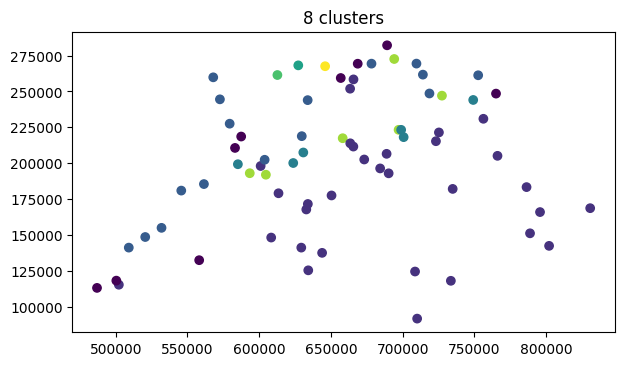

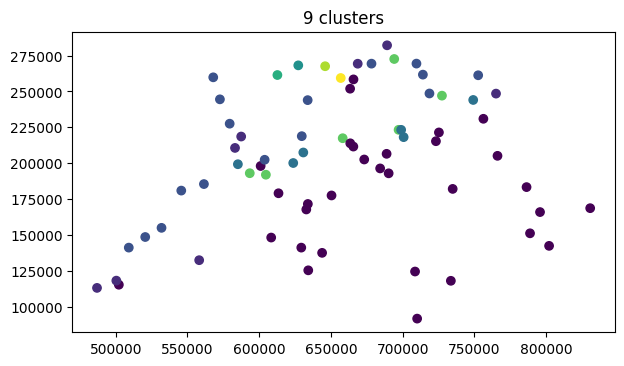

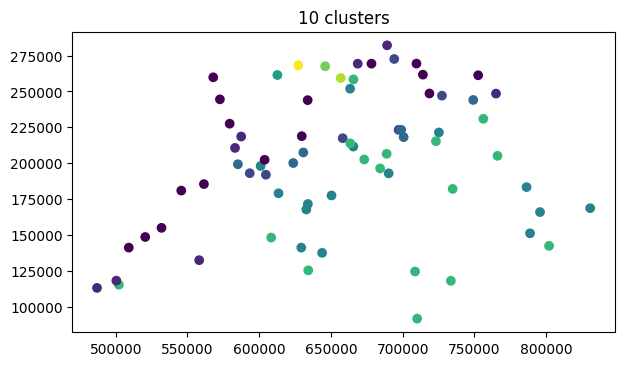

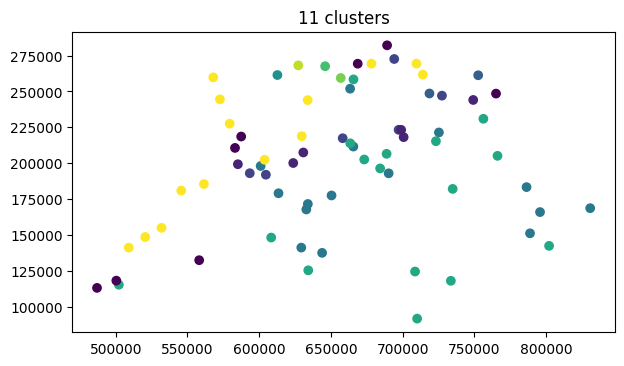

In [5]:
# show clusters on map 
#read in the data
locations_df = pd.read_csv("C:/Users/janzu/OneDrive - Universitaet Bern/Documents/Informatik Studium/6. Semester/05_Bachelorarbeit/04_Code/first_jupyter_nb/01_Daten/stations_location.csv", sep=";")

#merge cluster labels with locations_df on Stationsnummer= Station_Nr
def merge_clusterlabels_map(cluster_labels):
    cluster_labels = pd.merge(cluster_labels, locations_df, left_on='Stationsnummer', right_on='Station_Nr')
    return cluster_labels
#plot the clusters with the locations of the stations

def plot_clusters_map( cluster_labels, num_clusters):

    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(cluster_labels['From_Node_X'] , cluster_labels['From_Node_Y'], c=cluster_labels[num_clusters + ' clusters'])
    ax.set_title(num_clusters +' clusters')
    ax.set_aspect('equal')
    #print name of each station to the point
    # for i, txt in enumerate(cluster_labels_kmeans_map['Station_Name']):
    #     ax.annotate(txt, (cluster_labels_kmeans_map['From_Node_X'][i], cluster_labels_kmeans_map['From_Node_Y'][i]))
    plt.show()

for i in range(2,12):
    plot_clusters_map(merge_clusterlabels_map(cluster_labels_hierachical_additional), str(i))


